In [46]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [47]:
data_reliability = pd.read_csv("../data/reliability_synthetic.csv")
display(data_reliability.head())

,Device_ID,Test_Type,Stress_Temperature_C,Stress_Voltage_V,Failure_Time_Hours,Censored,Batch_ID
0,D0001,HTOL,125,4.5,624.701,0,B4
1,D0002,HTOL,125,4.5,992.238,0,B4
2,D0003,HTOL,125,4.5,522.748,0,B3
3,D0004,HTOL,125,4.5,465.29,0,B2
4,D0005,HTOL,125,4.5,287.708,0,B2


In [62]:
data_reliability.shape

(560, 7)

In [61]:
display(data_reliability.describe(include="all"))

,Device_ID,Test_Type,Stress_Temperature_C,Stress_Voltage_V,Failure_Time_Hours,Censored,Batch_ID
count,560,560,560,560,560,560,560
unique,560,3,NaN,NaN,NaN,NaN,4
top,D0001,HTOL,NaN,NaN,NaN,NaN,B3
freq,1,320,NaN,NaN,NaN,NaN,151
mean,NaN,NaN,102.857,3.18571,848.561,0.392857,NaN
std,NaN,NaN,61.7489,2.08405,484.947,0.488822,NaN
min,NaN,NaN,-40,0,40.8678,0,NaN
25%,NaN,NaN,85,0,375.982,0,NaN
50%,NaN,NaN,125,4.5,925.696,0,NaN
75%,NaN,NaN,150,5,1200,1,NaN


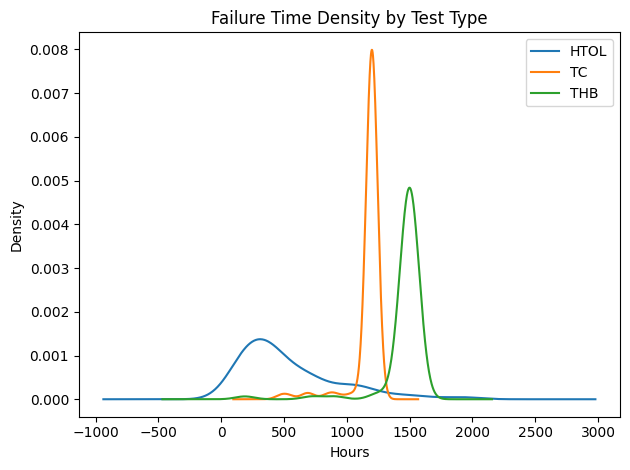

In [63]:
# histogram by test type
plt.figure()
for tt, sub in data_reliability.groupby("Test_Type"):
    sub["Failure_Time_Hours"].plot(kind="kde", label=tt)
plt.title("Failure Time Density by Test Type")
plt.xlabel("Hours"); plt.legend(); plt.tight_layout()
plt.savefig("../results/density_by_testtype.png", dpi=150); plt.show()

In [50]:
data_reliability.columns

Index(['Device_ID', 'Test_Type', 'Stress_Temperature_C', 'Stress_Voltage_V', 'Failure_Time_Hours', 'Censored', 'Batch_ID'], dtype='object')

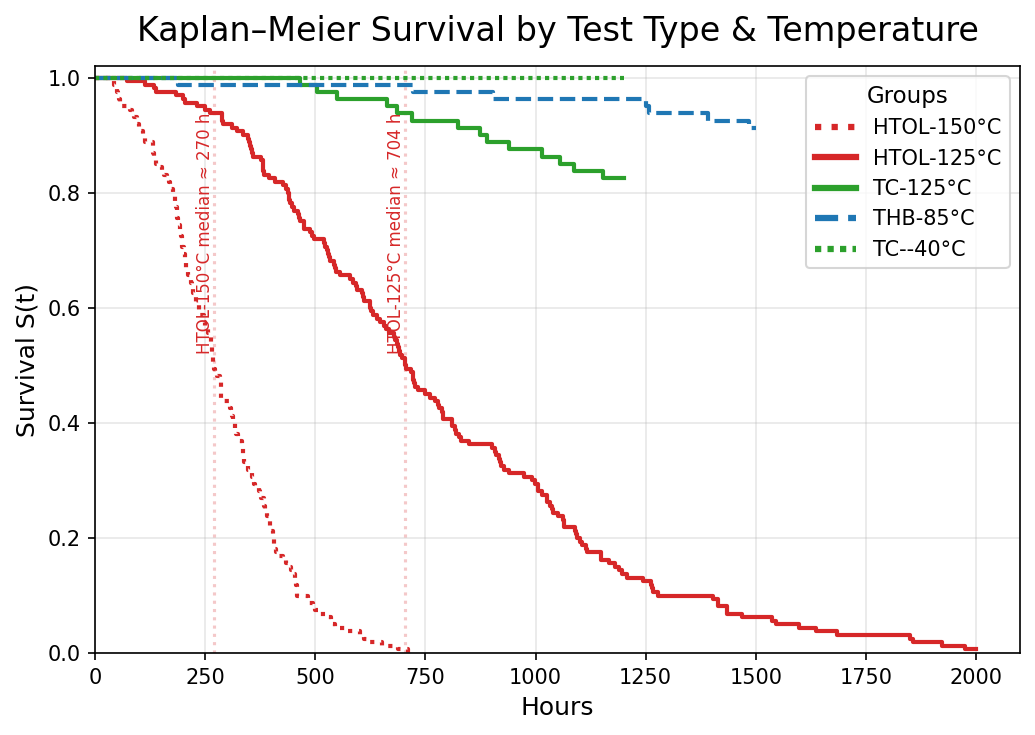

,Test_Type,Temp_C,median_hours
1,HTOL,125,703.985
0,HTOL,150,269.957
4,TC,-40,inf
2,TC,125,inf
3,THB,85,inf


In [51]:
df = data_reliability.copy()

# --- styling maps ---
palette = {"HTOL": "#d62728", "THB": "#1f77b4", "TC": "#2ca02c"}  # fixed by test type
linestyles = {-40: (0, (1, 1)), 85: "--", 125: "-", 150: ":"}     # by temperature

# Order groups in a logical way for legend/readability
preferred_order = [("HTOL", 150), ("HTOL", 125), ("TC", 125), ("THB", 85), ("TC", -40)]

groups = df.groupby(["Test_Type", "Stress_Temperature_C"])
km = KaplanMeierFitter()

plt.figure(figsize=(7, 5), dpi=150)

median_rows = []  # collect median survival per group

# Plot in preferred order if present, then any remaining groups
seen = set()
ordered_keys = [g for g in preferred_order if g in groups.groups]
ordered_keys += [k for k in groups.groups.keys() if k not in set(ordered_keys)]

for (tt, T) in ordered_keys:
    sub = groups.get_group((tt, T)).sort_values("Failure_Time_Hours")
    label = f"{tt}-{T}°C"

    km.fit(
        durations=sub["Failure_Time_Hours"],
        event_observed=1 - sub["Censored"],
        label=label
    )

    # main KM curve
    km.plot(
        ci_show=False,
        color=palette.get(tt, "black"),
        ls=linestyles.get(T, "-"),
        linewidth=2
    )

    # capture median survival if it exists (curve crosses 0.5)
    med = km.median_survival_time_
    if np.isfinite(med):
        plt.axvline(med, color=palette.get(tt, "black"), ls=":", alpha=0.25)
        plt.text(
            med, 0.52, f"{label} median ≈ {med:.0f} h",
            rotation=90, va="bottom", ha="right", fontsize=8, color=palette.get(tt, "black")
        )
        median_rows.append({"Test_Type": tt, "Temp_C": T, "median_hours": float(med)})
    else:
        median_rows.append({"Test_Type": tt, "Temp_C": T, "median_hours": np.inf})

plt.title("Kaplan–Meier Survival by Test Type & Temperature", fontsize=16, pad=12)
plt.xlabel("Hours", fontsize=12)
plt.ylabel("Survival S(t)", fontsize=12)
plt.grid(alpha=0.3)
plt.ylim(0, 1.02); plt.xlim(left=0)
leg = plt.legend(frameon=True, title="Groups", fontsize=10, title_fontsize=11, loc="upper right")
for line in leg.get_lines(): line.set_linewidth(3)

plt.tight_layout()
plt.savefig("../results/km_by_group_publication.png", dpi=200)
plt.show()

# Save medians for your results folder (handy in README/CL)
med_df = pd.DataFrame(median_rows).sort_values(["Test_Type","Temp_C"])
med_df.to_csv("../results/km_medians_by_group.csv", index=False)
med_df

In [56]:
# DIAG: Inspect one group's fit object to see available attributes/keys
(tt, T, V), sub = next(iter(df.groupby(["Test_Type","Stress_Temperature_C","Stress_Voltage_V"])))
failures = sub.loc[sub["Censored"]==0,"Failure_Time_Hours"].values
censored = sub.loc[sub["Censored"]==1,"Failure_Time_Hours"].values
fit = Fit_Weibull_2P(failures=failures, right_censored=censored if len(censored) else None, show_probability_plot=False, print_results=False)

print("Direct attrs:", [k for k in dir(fit) if k in ("beta","eta","MTTF","Beta","Eta")])
print("type(fit.results):", type(getattr(fit, "results", None)))
print("results keys preview:", getattr(getattr(fit, "results", {}), "keys", lambda: [])())


Direct attrs: ['beta']
type(fit.results): <class 'pandas.core.frame.DataFrame'>
results keys preview: Index(['Parameter', 'Point Estimate', 'Standard Error', 'Lower CI', 'Upper CI'], dtype='object')


In [59]:
# Pick one group and inspect its fit.results exactly
(tt, T, V), sub = next(iter(data_reliability.groupby(["Test_Type", "Stress_Temperature_C", "Stress_Voltage_V"])))
failures = sub.loc[sub["Censored"] == 0, "Failure_Time_Hours"].values
censored = sub.loc[sub["Censored"] == 1, "Failure_Time_Hours"].values

fit = Fit_Weibull_2P(failures=failures, right_censored=censored if len(censored) else None,
                     show_probability_plot=False, print_results=False)

print(fit.results)


  Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
0     Alpha         915.954         52.9794   817.786   1025.91
1      Beta         2.04717         0.17417   1.73274   2.41865


In [60]:
# CELL C+++ (final): Grouped Weibull fits for your version of reliability
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma
from reliability.Fitters import Fit_Weibull_2P

df = data_reliability.copy()
MIN_FAILS = 5

rows, skipped = [], []

for (tt, T, V), sub in df.groupby(["Test_Type", "Stress_Temperature_C", "Stress_Voltage_V"]):
    failures = sub.loc[sub["Censored"] == 0, "Failure_Time_Hours"].values
    censored = sub.loc[sub["Censored"] == 1, "Failure_Time_Hours"].values

    if len(failures) < MIN_FAILS:
        skipped.append({
            "Test_Type": tt, "Temp_C": T, "Volt_V": V,
            "n_total": len(sub), "n_fail": len(failures), "n_censored": len(censored)
        })
        continue

    fit = Fit_Weibull_2P(
        failures=failures,
        right_censored=censored if len(censored) else None,
        show_probability_plot=False,
        print_results=False
    )

    # Extract Alpha (eta) and Beta from fit.results DataFrame
    res_df_fit = fit.results
    eta = float(res_df_fit.loc[res_df_fit["Parameter"].str.lower() == "alpha", "Point Estimate"].iloc[0])
    beta = float(res_df_fit.loc[res_df_fit["Parameter"].str.lower() == "beta", "Point Estimate"].iloc[0])

    # Compute MTTF = eta * Gamma(1 + 1/beta)
    mttf = eta * gamma(1.0 + 1.0/beta)

    if beta < 0.9:      hazard_note = "Decreasing hazard (infant mortality)"
    elif beta <= 1.1:   hazard_note = "~Constant hazard (random failures)"
    else:               hazard_note = "Increasing hazard (wear-out)"

    rows.append({
        "Test_Type": tt, "Temp_C": T, "Volt_V": V,
        "n_total": int(len(sub)),
        "n_fail": int(len(failures)),
        "n_censored": int(len(censored)),
        "beta_shape": beta,
        "eta_scale_hours": eta,
        "MTTF_hours": mttf,
        "hazard_interpretation": hazard_note
    })

res_df = pd.DataFrame(rows).sort_values(["Test_Type","Temp_C","Volt_V"]).reset_index(drop=True)
display(res_df)
res_df.to_csv("../results/weibull_group_fits.csv", index=False)

if skipped:
    print("\nSkipped groups (too few observed failures):")
    display(pd.DataFrame(skipped).sort_values(["Test_Type","Temp_C","Volt_V"]).reset_index(drop=True))


,Test_Type,Temp_C,Volt_V,n_total,...,beta_shape,eta_scale_hours,MTTF_hours,hazard_interpretation
0,HTOL,125,4.5,80,...,2.04717,915.954,811.453,Increasing hazard (wear-out)
1,HTOL,125,5,80,...,2.00396,861.18,763.174,Increasing hazard (wear-out)
2,HTOL,150,4.5,80,...,2.22402,341.343,302.316,Increasing hazard (wear-out)
3,HTOL,150,5,80,...,2.09631,313.256,277.452,Increasing hazard (wear-out)
4,TC,125,0,80,...,2.48805,2318.17,2056.59,Increasing hazard (wear-out)
5,THB,85,3.3,80,...,1.8955,5312.11,4714.13,Increasing hazard (wear-out)



Skipped groups (too few observed failures):


,Test_Type,Temp_C,Volt_V,n_total,n_fail,n_censored
0,TC,-40,0,80,0,80


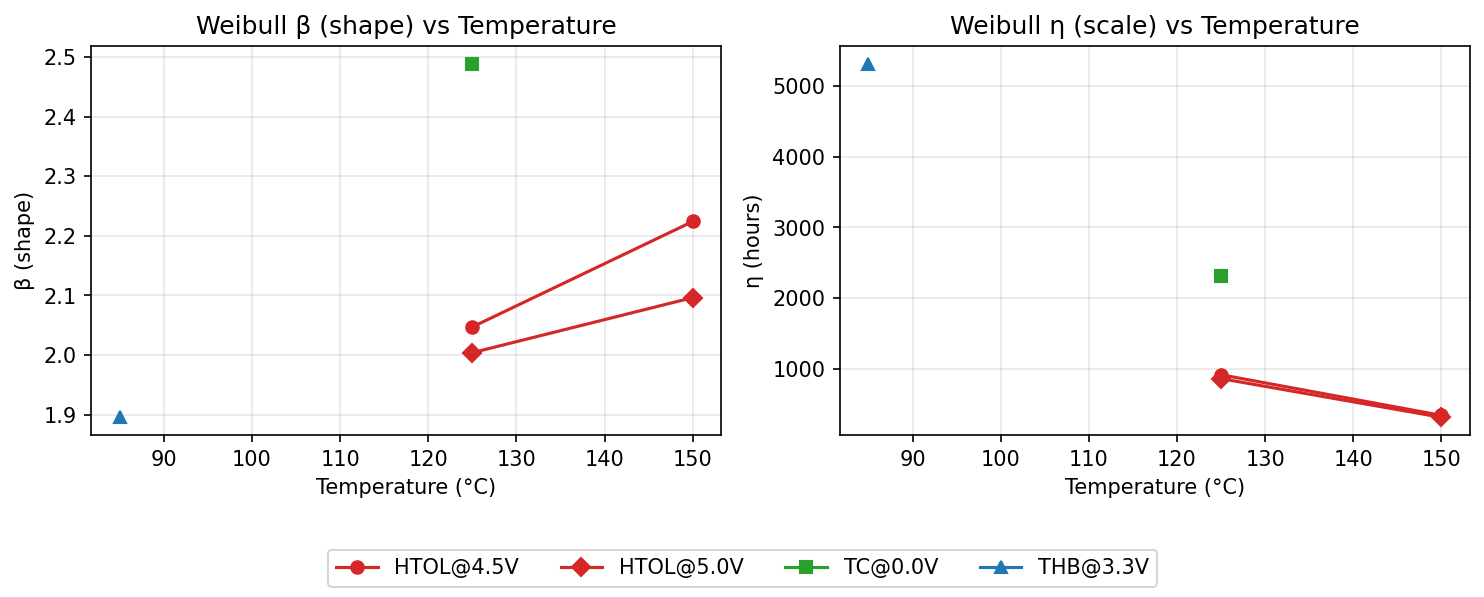

In [64]:
# β and η vs Temperature (color by Test_Type, marker by Voltage)
colors = {"HTOL":"#d62728","THB":"#1f77b4","TC":"#2ca02c"}
markers = {0.0:"s", 3.3:"^", 4.5:"o", 5.0:"D"}

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

for tt, g in res_df.groupby("Test_Type"):
    for V, gg in g.groupby("Volt_V"):
        axes[0].plot(gg["Temp_C"], gg["beta_shape"], marker=markers.get(V,"o"),
                     linestyle="-", color=colors.get(tt,"black"), label=f"{tt}@{V}V")
        axes[1].plot(gg["Temp_C"], gg["eta_scale_hours"], marker=markers.get(V,"o"),
                     linestyle="-", color=colors.get(tt,"black"), label=f"{tt}@{V}V")

axes[0].set_title("Weibull β (shape) vs Temperature")
axes[0].set_xlabel("Temperature (°C)")
axes[0].set_ylabel("β (shape)")
axes[0].grid(alpha=0.3)

axes[1].set_title("Weibull η (scale) vs Temperature")
axes[1].set_xlabel("Temperature (°C)")
axes[1].set_ylabel("η (hours)")
axes[1].grid(alpha=0.3)

handles, labels = axes[1].get_legend_handles_labels()
uniq = dict(zip(labels, handles))
fig.legend(uniq.values(), uniq.keys(), loc="lower center", ncol=4, frameon=True)

plt.tight_layout(rect=(0,0.12,1,1))
plt.savefig("../results/weibull_group_params_vs_temp.png", dpi=300)
plt.show()


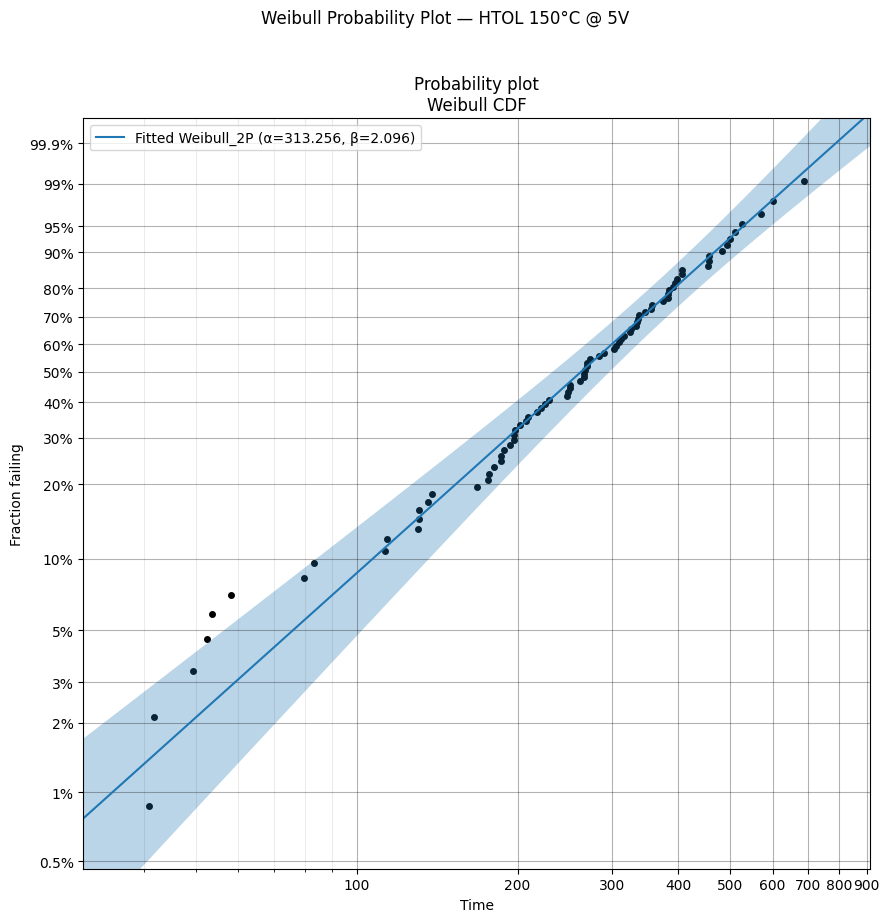

In [66]:
# CELL D (version-agnostic): Weibull probability plot for HTOL-150C @ 5V
import matplotlib.pyplot as plt
from reliability.Fitters import Fit_Weibull_2P

sel = data_reliability.query(
    "Test_Type=='HTOL' & Stress_Temperature_C==150 & Stress_Voltage_V==5.0"
)
fail = sel.loc[sel["Censored"]==0, "Failure_Time_Hours"].values
cen  = sel.loc[sel["Censored"]==1, "Failure_Time_Hours"].values

# This call renders the Weibull probability plot internally
fit = Fit_Weibull_2P(
    failures=fail,
    right_censored=cen if len(cen) else None,
    show_probability_plot=True,
    print_results=False
)

plt.suptitle("Weibull Probability Plot — HTOL 150°C @ 5V", y=1.02)
plt.tight_layout()
plt.savefig("../results/weibull_probability_plot_HTOL_150C_5V.png", dpi=300, bbox_inches="tight")
plt.show()


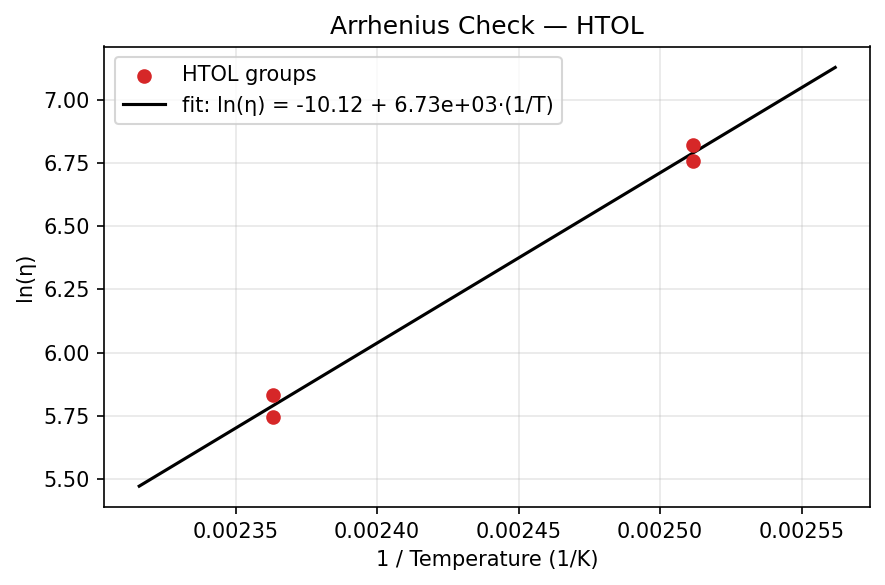

In [67]:
# CELL E: Arrhenius trend using ln(η) vs 1/T for HTOL groups
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter for HTOL groups only
arr = res_df[res_df["Test_Type"] == "HTOL"].copy()
arr["Temp_K"] = arr["Temp_C"] + 273.15
arr["invT"] = 1.0 / arr["Temp_K"]  # inverse temperature in 1/K
arr["ln_eta"] = np.log(arr["eta_scale_hours"])

# Linear regression: ln(η) = a + b*(1/T)
x = arr["invT"].values
y = arr["ln_eta"].values
A = np.vstack([np.ones_like(x), x]).T
coef, *_ = np.linalg.lstsq(A, y, rcond=None)
a, b = coef  # intercept, slope

# Predict for plotting
xgrid = np.linspace(x.min()*0.98, x.max()*1.02, 100)
yhat = a + b * xgrid

# Plot
plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(x, y, label="HTOL groups", color="#d62728", zorder=3)
plt.plot(xgrid, yhat, label=f"fit: ln(η) = {a:.2f} + {b:.2e}·(1/T)", color="black", lw=1.5)
plt.xlabel("1 / Temperature (1/K)")
plt.ylabel("ln(η)")
plt.title("Arrhenius Check — HTOL")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("../results/arrhenius_lneta_vs_invT_HTOL.png", dpi=300)
plt.show()

# Save coefficients to CSV
pd.DataFrame([{"intercept_a": a, "slope_b": b}]).to_csv("../results/arrhenius_fit_coeffs_HTOL.csv", index=False)